## This is the second microtask for the project: Reporting CHAOSS Metrics under the CHAOSS org in GSoC-18.

The task is to: ***Produce a chart showing the distribution of time-to-close (using the corresponding field in the GrimoireLab enriched index for GitHub issues) for issues already closed, and opened during the last six months.***

We start by importing the necessary modules.

In [5]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
from IPython.display import display
from dateutil.relativedelta import relativedelta
from calendar import monthrange, month_name
from collections import defaultdict, OrderedDict
from elasticsearch_dsl import Search
from pprint import pprint

import subprocess
import pandas as pd

And by specifying the necessary variables.

In [6]:
# Elasticsearch should be running at this URL, otherwise the next command will give and error
ES_URL = "http://localhost:9200" 

es = Elasticsearch(ES_URL, verify_certs = False)

# details of the repository to be analysed
parent_org_of_repo = "aimacode"
name_of_repo = "aima-python"

# Names of the indices by which the repository will be stored
enriched_index_name = "aima_python_github"
raw_index_name = "aima_python_github_raw"

# This token will allow us to call GitHub's api without being rate limited 
github_access_token = ""

There is a much more stringent limit if no token is provided which won't work if we want to request large amount of data. You can learn how to generate your token [here](https://github.com/blog/1509-personal-api-tokens).

### Getting the data

Now we will use `p2o.py` and **`github`** to get the repository, and insert it into elasticsearch.  
This command will index 2 versions of the repository: a raw version and an enriched version.
`p2o.py` gets the data for the repository (such as pull request, their creation and closing date, issues and other meta data) and uploads the raw version of it. Then it enriches the data i.e adds paramerets such as `time to close days`, `time open days`, `item type` (pull request or issue) and so on.  
These additional fields provide us with more insights to the activity in the repository.

This command will take some time to run, depending upon the size of the repository. You can refresh and check if any new indices were created at your elasticsearch instance.

In [ ]:
subprocess.run(['p2o.py', '--enrich', '--index', raw_index_name,
      '--index-enrich', enriched_index_name, '-e', ES_URL,
      '--no_inc', '--debug', 'github', parent_org_of_repo , name_of_repo,
      '-t', github_access_token, '--sleep-for-rate'])
print("Done!")

This command can take some time to run.

### Analysis

Unlike the previous task, in this task, we will be making the use of `Elasticsearch_dsl` module. It provides a high level api over `Elasticsearch.py` module which makes creating the queries, adding filters and creating aggregations much easier.

We start by creating a `Search` object.

In [10]:
s = Search(using=es, index=enriched_index_name)

In [11]:
# We add the fields that we want in the results.
s = s.source(['created_at', 'time_to_close_days', 'time_open_days', 'item_type', 'closed_at', 'author_name', 
              'id_in_repo'])

# As we are only looking for issues, we shall specify that in "item_type"
s = s.filter('terms', item_type=['issue'])

# We are looking for all the issues that were created in the last 6 months.
s = s.filter('range', created_at={'gte' : 'now-6M'})

# And we are going to arrange all these documents according to when they were created in ascending order
s = s.sort({'created_at': { 'order' : 'asc'}})

# To capture all the documents, we have kept the size as 1000. You can change it according to your needs.
s = s[0:1000]

This is what the query looks like now:

In [12]:
s.to_dict()

{'_source': ['created_at',
  'time_to_close_days',
  'time_open_days',
  'item_type',
  'closed_at',
  'author_name',
  'id_in_repo'],
 'from': 0,
 'query': {'bool': {'filter': [{'terms': {'item_type': ['issue']}},
    {'range': {'created_at': {'gte': 'now-6M'}}}]}},
 'size': 1000,
 'sort': [{'created_at': {'order': 'asc'}}]}

Let's capture all the results and print one of them

In [13]:
result = s.execute()

# Convert the above results to a dictionary
result = result.to_dict()

In [14]:
pprint(result['hits']['hits'][0])
print()
print("Total number of docs: ", result['hits']['total'])

{'_id': '31eb3b1b2808000cd8278e1677c9dd06a85bf607',
 '_index': 'aima_python_github',
 '_score': None,
 '_source': {'author_name': 'Peter Norvig',
             'closed_at': '2017-09-09T03:26:01Z',
             'created_at': '2017-08-27T17:40:56Z',
             'id_in_repo': '636',
             'item_type': 'issue',
             'time_open_days': 12.41,
             'time_to_close_days': 12.41},
 '_type': 'items',
 'sort': [1503855656000]}

Total number of docs:  47


Let's convert these documents into a Pandas dataframe and do some data preprocessing.

In [17]:
issues = [issue['_source'] for issue in result['hits']['hits']]

issues = pd.DataFrame(issues)

# We fill all te NaN values with zero
issues = issues.fillna(0)

Now, using pandas.DataFrame.plot function, we can plot the `time_open_days`, `time_to_close_days` and the `issue id`.

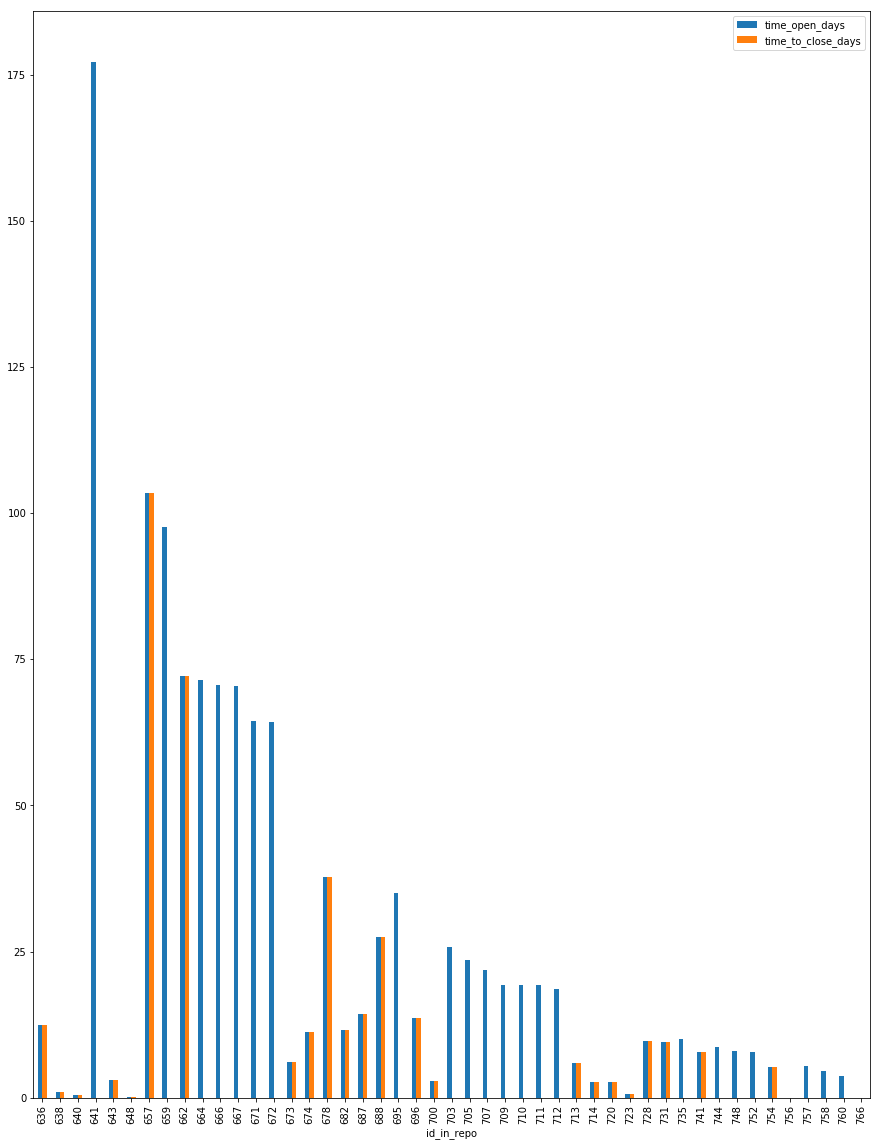

In [19]:
issues.plot(x=issues['id_in_repo'], kind='bar', figsize=(15,20));

This concludes our second Microtask.